In [97]:
library(tidyverse)
install.packages('nycflights13')
library(nycflights13)

remotes::install_github("bradleyboehmke/harrypotter")
install.packages("tidytext")
library(harrypotter)

Installing package into ‘/home/terhorst/R/x86_64-pc-linux-gnu-library/4.2’
(as ‘lib’ is unspecified)

Skipping install of 'harrypotter' from a github remote, the SHA1 (51f71461) has not changed since last install.
  Use `force = TRUE` to force installation

Installing package into ‘/home/terhorst/R/x86_64-pc-linux-gnu-library/4.2’
(as ‘lib’ is unspecified)



# Lecture 17: Iteration and Functional Programming
<div style="border: 1px double black; padding: 10px; margin: 10px">

**After today's lecture you will understand:**
- [Iteration](#Iteration): `for`/`while` loops.
- [Functional programming](#Functional-programming) (FP): functions that operate on other functions.
</div>

These notes correspond to Chapter 27 of the book.

## Doing the same thing over and over again
Very often in programming, it happens that you need to perform the same "action" on multiple "things". Examples we have already seen in this class:
- `facet_wrap()`, `facet_grid()`: make the same plot for various combinations of factors.
- `group_by()` + `summarize()`: compute the same statistic for various groups of data.

We've also encountered examples where we needed to do the same thing repeatedly, but didn't have a ready-made function (so probably resorted to copy-paste). E.g. HW7: bind together all the Harry Potter books into one data frame.

### Performing the same action on multiple columns
Consider the following table with four columns `a`-`d`:

In [114]:
df <- tibble(
  a = rnorm(10),
  b = rnorm(10),
  c = rnorm(10),
  d = rnorm(10)
) 

Yesterday we wrote a `z_score()` function which standardizes a vector of data to have unit variance and zero mean:

In [115]:
z_score <- function(x, na.rm = F) {
    (x - mean(x, na.rm = na.rm)) / sd(x, na.rm = na.rm)
}

Let's say we want to standardize the four coulmns in our data frame. Up to now, we would probably write:

In [123]:
# mutate the manual way 
df %>% mutate(a = range01(a), b = z_score(b), c = range01(c), d = range01(d))

a,b,c,d
<dbl>,<dbl>,<dbl>,<dbl>
0.72409008,-0.70393143,1.1924754,-0.29949827
-1.56141654,-0.07890655,-1.1618429,0.89801898
1.86022146,0.93414487,1.5561287,1.32706682
-0.56019743,-0.15215302,-0.3015393,-0.34896719
-1.23747188,-2.05026789,0.5334608,1.40534872
0.67424650,0.93353630,-0.8232924,-1.63661498
0.34006590,0.88949916,-1.0047129,-0.07999729
0.03132767,-0.14920954,1.0098690,-0.03483162
0.11373725,1.09493961,-0.1660276,0.01828132


In the preceding example, we just copy-pasted the same bit of code four times. From now on, we shall adopt a rule: "never copy-paste more than twice!" If you find yourself copy-pasting code more than two times, it pays to think of a better way to accomplish the task at hand.

### `across()`
The better way in this case is to use a new `dplyr` verb called `across()`. It's easiest to explain with an example:

In [126]:
# use across instead
df %>% mutate( across(c(a, b, c, d), range01) )

a,b,c,d
<dbl>,<dbl>,<dbl>,<dbl>
0.72409008,-0.70393143,1.1924754,-0.29949827
-1.56141654,-0.07890655,-1.1618429,0.89801898
1.86022146,0.93414487,1.5561287,1.32706682
-0.56019743,-0.15215302,-0.3015393,-0.34896719
-1.23747188,-2.05026789,0.5334608,1.40534872
0.67424650,0.93353630,-0.8232924,-1.63661498
0.34006590,0.88949916,-1.0047129,-0.07999729
0.03132767,-0.14920954,1.0098690,-0.03483162
0.11373725,1.09493961,-0.1660276,0.01828132


The columns selected by `across()` work in the same way as `select`:

In [155]:
# standardize everything except column a, then compute the mean

df %>% mutate(across(-a, z_score) ) %>% 
   summarize(across(a:d, \(vec) mean(vec, na.rm = T)))

a,b,c,d
<dbl>,<dbl>,<dbl>,<dbl>
0.656898,-2.637864e-17,8.05237e-17,-1.872417e-17


### Selecting columns based on their type
It only makes sense to standardize a numerical random variable. Hence, the following won't work:

    mpg %>% mutate(across(everything(), z_score))
    
    

Instead, we can use `where()` to select columns that have a particular type:

In [151]:
# standardize only the numerical columns

mpg %>% mutate(across(is.numeric, z_score))

# is.numeric(mpg$cty)

Warning message:
“There was 1 warning in `mutate()`.
ℹ In argument: `across(is.numeric, z_score)`.
Caused by warning:
! Use of bare predicate functions was deprecated in tidyselect 1.1.0.
ℹ Please use wrap predicates in `where()` instead.
  # Was:
  data %>% select(is.numeric)

  # Now:
  data %>% select(where(is.numeric))”


manufacturer,model,displ,year,cyl,trans,drv,cty,hwy,fl,class
<chr>,<chr>,<dbl>,<dbl>,<dbl>,<chr>,<chr>,<dbl>,<dbl>,<chr>,<chr>
audi,a4,-1.2939999,-0.997861,-1.1721058,auto(l5),f,0.26810155,0.93369639,p,compact
audi,a4,-1.2939999,-0.997861,-1.1721058,manual(m5),f,0.97299777,0.93369639,p,compact
audi,a4,-1.1391962,0.997861,-1.1721058,manual(m6),f,0.73803236,1.26956872,p,compact
audi,a4,-1.1391962,0.997861,-1.1721058,auto(av),f,0.97299777,1.10163255,p,compact
audi,a4,-0.5199816,-0.997861,0.0689474,auto(l5),f,-0.20182926,0.42988788,p,compact
audi,a4,-0.5199816,-0.997861,0.0689474,manual(m5),f,0.26810155,0.42988788,p,compact
audi,a4,-0.2877761,0.997861,0.0689474,auto(av),f,0.26810155,0.59782405,p,compact
audi,a4 quattro,-1.2939999,-0.997861,-1.1721058,manual(m5),4,0.26810155,0.42988788,p,compact
audi,a4 quattro,-1.2939999,-0.997861,-1.1721058,auto(l5),4,-0.20182926,0.26195171,p,compact


### Anonymous functions
In the preceding example, we wrote a function, `z_score`, and then applied it to multiple columns using the `across()` verb. Often, we want to apply a relatively simple function that we are only going to use once. In these cases, we can define an "anonymous" function that only exists temporarily. 

In [25]:
#  df %>% summarize(across(a:d, median(na.rm = T))) won't work
# use anonymous function instead

a,b,c,d
<dbl>,<dbl>,<dbl>,<dbl>
-0.3486667,0.6316311,-0.003606294,-0.7484384


### Multiple columns at once
What if we want to use `across()` with multiple columns at once? 

In [167]:
# df %>% summarize(across(a:d, median, mean)) won't work -- use a named list instead

df %>% summarize(across(a:d, list(donuts = mean, croissants = median)))

a_donuts,a_croissants,b_donuts,b_croissants,c_donuts,c_croissants,d_donuts,d_croissants
<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
0.656898,0.7341174,-0.1804716,-0.2547415,0.8885315,0.7414305,-0.4171823,-0.477242


## `list()`

In the previous example we used a new data type that we have not seen before:

In [170]:
x <- list('a', 1L, FALSE, pi, list(1:3))
x

[[1]]
[1] "a"

[[2]]
[1] 1

[[3]]
[1] FALSE

[[4]]
[1] 3.141593

[[5]]
[[5]][[1]]
[1] 1 2 3

As the printout suggests, you can think of a list as a "vector of vectors". For this reason, they are sometimes referred to as "recursive vectors".

The `str` command will print out the **str**ucture of a vector:

In [171]:
str(x)

List of 5
 $ : chr "a"
 $ : int 1
 $ : logi FALSE
 $ : num 3.14
 $ :List of 1
  ..$ : int [1:3] 1 2 3


You can name each individual entry of a list:

In [39]:
x_named <- list(a = 1, b = 2, c = 3, 4)
names(x_named)
str(x_named)
x_named$a

[1] "a" "b" "c" ""

List of 4
 $ a: num 1
 $ b: num 2
 $ c: num 3
 $  : num 4


[1] 1

### Sub-setting lists
Subsetting lists is a little more complex than subsetting atomic vectors. We will use the following example list:

In [47]:
str(example_list <- list(a = 1:3, b = "a string", c = pi, d = list(-1, -5)))

List of 4
 $ a: int [1:3] 1 2 3
 $ b: chr "a string"
 $ c: num 3.14
 $ d:List of 2
  ..$ : num -1
  ..$ : num -5


#### `[]`
The `[]` operator extracts a sub-list. That is, the return type will always be a list:

In [41]:
x[1] %>% str

List of 1
 $ : chr "a"


#### `[[]]`
The double-brackets will extract a single component from the list:

In [42]:
x[[1]] %>% str

 chr "a"


### Data frames are lists
Many data types in R are actually lists plus some additional attributes. For example, tibbles and data frames are both lists:

In [173]:
# typeof(mpg) 
str(mpg)

tibble [234 × 11] (S3: tbl_df/tbl/data.frame)
 $ manufacturer: chr [1:234] "audi" "audi" "audi" "audi" ...
 $ model       : chr [1:234] "a4" "a4" "a4" "a4" ...
 $ displ       : num [1:234] 1.8 1.8 2 2 2.8 2.8 3.1 1.8 1.8 2 ...
 $ year        : int [1:234] 1999 1999 2008 2008 1999 1999 2008 1999 1999 2008 ...
 $ cyl         : int [1:234] 4 4 4 4 6 6 6 4 4 4 ...
 $ trans       : chr [1:234] "auto(l5)" "manual(m5)" "manual(m6)" "auto(av)" ...
 $ drv         : chr [1:234] "f" "f" "f" "f" ...
 $ cty         : int [1:234] 18 21 20 21 16 18 18 18 16 20 ...
 $ hwy         : int [1:234] 29 29 31 30 26 26 27 26 25 28 ...
 $ fl          : chr [1:234] "p" "p" "p" "p" ...
 $ class       : chr [1:234] "compact" "compact" "compact" "compact" ...


The `names()` of a tibble/data frame correspond to columns. This means we can use the list indexing methods shown above to access columns:

In [84]:
names(mpg)

 [1] "manufacturer" "model"        "displ"        "year"         "cyl"         
 [6] "trans"        "drv"          "cty"          "hwy"          "fl"          
[11] "class"       

## Lists and functional programming
Lists are useful to use because they can represent a sequence of values. Let's see an example from HW7: combining all the Harry Potter books into one data frame:

First, we need to load the library and get the names of all the books:

In [188]:
hp_titles <- ls('package:harrypotter') 
hp_titles

[1] "chamber_of_secrets"   "deathly_hallows"      "goblet_of_fire"      
[4] "half_blood_prince"    "order_of_the_phoenix" "philosophers_stone"  
[7] "prisoner_of_azkaban"

This has returned a character vector containing the seven titles in the database. To access any one of them, we can write:

In [190]:
 getExportedValue('harrypotter', hp_titles[2]) %>% str

 chr [1:37] "The two men appeared out of nowhere, a few yards apart in the narrow, moonlit lane. For a second they stood qui"| __truncated__ ...


## Iteration
Now let's think about how we can automate the process of joining all of these books into one data frame. 

If you're coming from a C++ or Java background, your first instinct is probably to use a `for()` loop. In R, for loops look like this:
```{r}
for (<index> in <vector>) {
    [do something for each value of <index>]
}
```

In [207]:
hp <- tibble()

for (x in hp_titles) {
    print(x)
    text <- getExportedValue('harrypotter', x)
    # make into data frame
    hp <- bind_rows(hp, tibble(text = text))
}

hp %>% print

[1] "chamber_of_secrets"
[1] "deathly_hallows"
[1] "goblet_of_fire"
[1] "half_blood_prince"
[1] "order_of_the_phoenix"
[1] "philosophers_stone"
[1] "prisoner_of_azkaban"
# A tibble: 200 × 1
   text                                                                         
   <chr>                                                                        
 1 "THE WORST BIRTHDAY　　Not for the first time, an argument had broken out ov…
 2 "　　DOBBY'S WARNING　　arry managed not to shout out, but it was a close th…
 3 "THE BURROW　　Ron.l\" breathed Harry, creeping to the window and pushing it…
 4 "AT FL0VRR 11 $ HAND BLOTTS　　ife at the Burrow was as different as possibl…
 5 "THE WHOMPING　　WILLOW　　he end of the summer vacation came too quickly fo…
 6 "GILDEROY LOCKHART　　he next day, however, Harry barely grinned once. Thing…
 7 "Harry looked bemusedly at the photograph Colin was brandishing under his no…
 8 "　　\"What are you talking about, Harry? Perhaps you're getting a litde dro…
 9 "THE WRTITING O

By tweaking this for loop, we could make it create a dataset of all the chapters in HP:

In [67]:
df <- tibble()
for (title in hp) {
    df <- bind_rows(df, tibble(title=title, text=getExportedValue('harrypotter', title)))
}
df %>% print

# A tibble: 200 × 2
   title              text                                                      
   <chr>              <chr>                                                     
 1 chamber_of_secrets "THE WORST BIRTHDAY　　Not for the first time, an argumen…
 2 chamber_of_secrets "　　DOBBY'S WARNING　　arry managed not to shout out, bu…
 3 chamber_of_secrets "THE BURROW　　Ron.l\" breathed Harry, creeping to the wi…
 4 chamber_of_secrets "AT FL0VRR 11 $ HAND BLOTTS　　ife at the Burrow was as d…
 5 chamber_of_secrets "THE WHOMPING　　WILLOW　　he end of the summer vacation …
 6 chamber_of_secrets "GILDEROY LOCKHART　　he next day, however, Harry barely …
 7 chamber_of_secrets "Harry looked bemusedly at the photograph Colin was brand…
 8 chamber_of_secrets "　　\"What are you talking about, Harry? Perhaps you're …
 9 chamber_of_secrets "THE WRTITING ON THE WALL　　What's going on here? What's…
10 chamber_of_secrets "　　THE ROGUE BLUDGER　　ince the disastrous episode of …
# … with 190 more rows


## `map()` 
An alternative to writing a for loop is to use the `map(f, seq)` function. This takes a function `f` and "maps" it over each element of a sequence (list or vector) `seq`.

![map](https://d33wubrfki0l68.cloudfront.net/f0494d020aa517ae7b1011cea4c4a9f21702df8b/2577b/diagrams/functionals/map.png)

In [215]:
hp_titles %>%
    map(\(title) getExportedValue('harrypotter', title)) %>% 
    map(\(text) tibble(text)) %>% 
    list_rbind %>% print

# A tibble: 200 × 1
   text                                                                         
   <chr>                                                                        
 1 "THE WORST BIRTHDAY　　Not for the first time, an argument had broken out ov…
 2 "　　DOBBY'S WARNING　　arry managed not to shout out, but it was a close th…
 3 "THE BURROW　　Ron.l\" breathed Harry, creeping to the window and pushing it…
 4 "AT FL0VRR 11 $ HAND BLOTTS　　ife at the Burrow was as different as possibl…
 5 "THE WHOMPING　　WILLOW　　he end of the summer vacation came too quickly fo…
 6 "GILDEROY LOCKHART　　he next day, however, Harry barely grinned once. Thing…
 7 "Harry looked bemusedly at the photograph Colin was brandishing under his no…
 8 "　　\"What are you talking about, Harry? Perhaps you're getting a litde dro…
 9 "THE WRTITING ON THE WALL　　What's going on here? What's going on?\" Attrac…
10 "　　THE ROGUE BLUDGER　　ince the disastrous episode of the pixies, Profess…
# … with 190 more rows


Finally, we need to take this list of dataframes and combine it into one large dataframe:

In [84]:
hp %>% 
    setNames(hp) %>% 
    map(\(title) tibble(text = getExportedValue('harrypotter', title))) %>%
    list_rbind(names_to = "title") %>% print

# A tibble: 200 × 2
   title              text                                                      
   <chr>              <chr>                                                     
 1 chamber_of_secrets "THE WORST BIRTHDAY　　Not for the first time, an argumen…
 2 chamber_of_secrets "　　DOBBY'S WARNING　　arry managed not to shout out, bu…
 3 chamber_of_secrets "THE BURROW　　Ron.l\" breathed Harry, creeping to the wi…
 4 chamber_of_secrets "AT FL0VRR 11 $ HAND BLOTTS　　ife at the Burrow was as d…
 5 chamber_of_secrets "THE WHOMPING　　WILLOW　　he end of the summer vacation …
 6 chamber_of_secrets "GILDEROY LOCKHART　　he next day, however, Harry barely …
 7 chamber_of_secrets "Harry looked bemusedly at the photograph Colin was brand…
 8 chamber_of_secrets "　　\"What are you talking about, Harry? Perhaps you're …
 9 chamber_of_secrets "THE WRTITING ON THE WALL　　What's going on here? What's…
10 chamber_of_secrets "　　THE ROGUE BLUDGER　　ince the disastrous episode of …
# … with 190 more rows


### Example: raw NCAA data
On HW8 you are analysing NCAA data. These data actually came from a much larger dataset spread across many files. The you can load the raw data here:

In [223]:
u <- "https://datasets.stats306.org/ncaa/ncaa_games_2004.csv.gz"  # contains data for 2002-2019
read_csv(u)

Rows: 27549 Columns: 11
── Column specification ─────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
Delimiter: ","
chr (5): opponent_name, game_date, location, neutral_site_location, game_length
dbl (6): score, opponent_score, attendence, opponent_id, year, school_id

ℹ Use `spec()` to retrieve the full column specification for this data.
ℹ Specify the column types or set `show_col_types = FALSE` to quiet this message.


opponent_name,game_date,score,opponent_score,location,neutral_site_location,game_length,attendence,opponent_id,year,school_id
<chr>,<chr>,<dbl>,<dbl>,<chr>,<chr>,<chr>,<dbl>,<dbl>,<dbl>,<dbl>
Texas A&M Int'l,11/22/2003,94,75,Home,NA,NA,2023,NA,2004,26172
Alcorn St.,11/25/2003,99,59,Home,NA,NA,1897,17,2004,26172
Baylor,11/29/2003,62,69,Away,NA,NA,4378,51,2004,26172
Sam Houston St.,12/03/2003,76,66,Home,NA,NA,1303,624,2004,26172
Morehead St.,12/06/2003,84,85,Away,NA,NA,2418,444,2004,26172
Air Force,12/09/2003,53,56,Home,NA,NA,1977,721,2004,26172
Texas A&M,12/13/2003,82,80,Away,NA,NA,4544,697,2004,26172
Kansas St.,12/20/2003,50,89,Away,NA,NA,5762,327,2004,26172
Prairie View,12/23/2003,80,51,Home,NA,NA,1274,553,2004,26172


Let's think about how we could combine these data into one big table for further analysis. First, we'll use a for loop:

In [231]:
# for loop way

template <- "https://datasets.stats306.org/ncaa/ncaa_games_{year}.csv.gz" 

ncaa <- tibble()
for (year in 2002:2019) {
    # load data for year
    u <- str_replace(template, fixed("{year}"), as.character(year))
    df.yr <- read_csv(u)
    ncaa <- bind_rows(ncaa, df.yr)
}

Rows: 27708 Columns: 11
── Column specification ─────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
Delimiter: ","
chr (5): opponent_name, game_date, location, neutral_site_location, game_length
dbl (6): score, opponent_score, attendence, opponent_id, year, school_id

ℹ Use `spec()` to retrieve the full column specification for this data.
ℹ Specify the column types or set `show_col_types = FALSE` to quiet this message.
Rows: 27253 Columns: 11
── Column specification ─────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
Delimiter: ","
chr (5): opponent_name, game_date, location, neutral_site_location, game_length
dbl (6): score, opponent_score, attendence, opponent_id, year, school_id

ℹ Use `spec()` to retrieve the full column specification for this data.
ℹ Specify the column types or set `show_col_types = FALSE` to quiet this


ℹ Use `spec()` to retrieve the full column specification for this data.
ℹ Specify the column types or set `show_col_types = FALSE` to quiet this message.
Rows: 31576 Columns: 11
── Column specification ─────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
Delimiter: ","
chr (5): opponent_name, game_date, location, neutral_site_location, game_length
dbl (6): score, opponent_score, attendence, opponent_id, year, school_id

ℹ Use `spec()` to retrieve the full column specification for this data.
ℹ Specify the column types or set `show_col_types = FALSE` to quiet this message.
Rows: 31566 Columns: 11
── Column specification ─────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
Delimiter: ","
chr (5): opponent_name, game_date, location, neutral_site_location, game_length
dbl (6): score, opponent_score, attendence, opponent_id, year, 

Next, we will use map:

In [239]:
str_c("https://datasets.stats306.org/ncaa/ncaa_games_", 2002:2019, ".csv.gz") %>% 
    map_dfr(read_csv) %>% str
    

Rows: 27708 Columns: 11
── Column specification ─────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
Delimiter: ","
chr (5): opponent_name, game_date, location, neutral_site_location, game_length
dbl (6): score, opponent_score, attendence, opponent_id, year, school_id

ℹ Use `spec()` to retrieve the full column specification for this data.
ℹ Specify the column types or set `show_col_types = FALSE` to quiet this message.
Rows: 27253 Columns: 11
── Column specification ─────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
Delimiter: ","
chr (5): opponent_name, game_date, location, neutral_site_location, game_length
dbl (6): score, opponent_score, attendence, opponent_id, year, school_id

ℹ Use `spec()` to retrieve the full column specification for this data.
ℹ Specify the column types or set `show_col_types = FALSE` to quiet this


ℹ Use `spec()` to retrieve the full column specification for this data.
ℹ Specify the column types or set `show_col_types = FALSE` to quiet this message.
Rows: 31576 Columns: 11
── Column specification ─────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
Delimiter: ","
chr (5): opponent_name, game_date, location, neutral_site_location, game_length
dbl (6): score, opponent_score, attendence, opponent_id, year, school_id

ℹ Use `spec()` to retrieve the full column specification for this data.
ℹ Specify the column types or set `show_col_types = FALSE` to quiet this message.
Rows: 31566 Columns: 11
── Column specification ─────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
Delimiter: ","
chr (5): opponent_name, game_date, location, neutral_site_location, game_length
dbl (6): score, opponent_score, attendence, opponent_id, year, 

spc_tbl_ [542,797 × 11] (S3: spec_tbl_df/tbl_df/tbl/data.frame)
 $ opponent_name        : chr [1:542797] "Sul Ross St." "Texas St." "Loyola Chicago" "Illinois" ...
 $ game_date            : chr [1:542797] "11/16/2001" "11/25/2001" "11/29/2001" "12/01/2001" ...
 $ score                : num [1:542797] 93 89 66 56 64 56 67 80 81 92 ...
 $ opponent_score       : num [1:542797] 59 99 86 80 89 82 69 75 79 83 ...
 $ location             : chr [1:542797] "Home" "Home" "Away" "Away" ...
 $ neutral_site_location: chr [1:542797] NA NA NA NA ...
 $ game_length          : chr [1:542797] NA NA NA NA ...
 $ attendence           : num [1:542797] 2041 1493 1128 16500 6099 ...
 $ opponent_id          : num [1:542797] 1390 670 371 301 703 704 346 629 183 NA ...
 $ year                 : num [1:542797] 2002 2002 2002 2002 2002 ...
 $ school_id            : num [1:542797] 26172 26172 26172 26172 26172 ...
 - attr(*, "spec")=
  .. cols(
  ..   opponent_name = col_character(),
  ..   game_date = col_charact

Do you find the `map()` way easier to use? Easier to read? More enjoyable to write? (Hopefully at least one of the three.)

## `while`

The last kind of loop we will consider is `while()`. 

A while statement can be useful when you aren’t sure how many iterations are needed. This happens sometimes in statistics or data science when you are simulating a random quantity. 

Here is an example that takes a random walk and terminates if the value is more than 10 units from 0.

In [241]:
i <- 0
while (i < 10) {
    print(i)
}

[1] 0
[1] 1
[1] 2
[1] 3
[1] 4
[1] 5
[1] 6
[1] 7
[1] 8
[1] 9


## Example: random walk
A random walk is a 

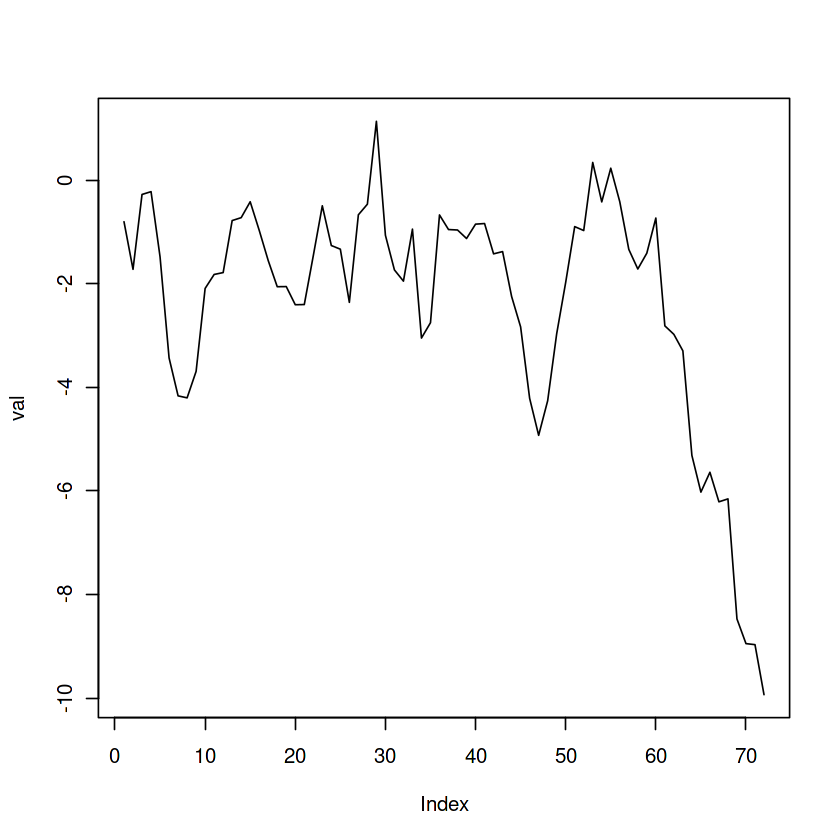

In [245]:
maxIter = 1e3 # always limit the total iterations allowed
val = vector(mode = 'numeric', length = maxIter)
val[1] = rnorm(1) ## initialize

k = 1
while (abs(val[k]) < 10 && k <= maxIter) {
  val[k + 1] = val[k] + rnorm(1)
  k = k + 1
}
val = val[1:k-1]

plot(val, type = 'l')

#### key words
The following key words are useful within loops:

- break - break out of the currently executing loop
- next - move to the next iteration immediately, without executing the rest of this iteration (continue in other languages such as C++)

Here is an example using next:



In [ ]:
for ( i in 1:10 ) {
  if (i %% 2 == 0) next
  cat(i,'\n')
}

1 
3 
5 
7 
9 


## Conditional execution

Often when writing functions we need to do different things depending on what data is passed in. This is known as conditional execution, and is accomplished using the if and/or else construct:

```
if (condition) {
  # code executed when condition is TRUE
} else {
  # code executed when condition is FALSE
}
```



#### if statements

The workhorse for conditional execution in `R` is the if statement.
In the syntax below, note the spacing around the condition enclosed in the parentheses.

In [21]:
if ( TRUE ) {  # this condition is hard-coded to TRUE and will also execute the if-block
  print('do something if true')
}

[1] "do something if true"


## Optional `else` block

Use an else to control the flow without separately checking the condition’s negation:



In [35]:
if ((2 + 2) == 5 ) {
  print('the statement is true')
} else {
  print('the statement is false')
}

[1] "the statement is false"


### `ifelse` function

ifelse() is a function that takes three vector arguments and returns a new vector. As you can see this is not the same as above

In [32]:
# Define a vector
x <- c(1, 2, 3, 4, 5)

# Use ifelse to create a new vector
y <- ifelse(x > 3, "large", "small")

y

[1] "small" "small" "small" "large" "large"

# What about if_else?

`if_else` comes from dplyr and works the same as ifelse except the output from the if_else should be of the same type

In [39]:
y <- if_else(x > 3, "large", 10)
y

ERROR: ignored

### if-else chain

For more complex cases, you may want to check multiple conditions:

In [ ]:
a = -1
b = 1

if (a * b > 0) {
  print('Zero is not between a and b')
} else if ( a < b ) {
    smaller = a
    larger = b
} else {
    smaller = b
    larger  = a
}

c(smaller, larger)

[1] -1  1

## The wiki-link game
To illustrate how and when to write functions, we will write a program that plays the [wiki-link game](https://en.wikipedia.org/wiki/Wikipedia:Wiki-Link_Game). An abbreviate version of the rules are:

1. Pick a whole number between 1 and 8 -- call it $N$.
2. Pick a random page on Wikipedia by visiting [the random page page](https://en.wikipedia.org/wiki/Special:Random).
3. Now read the article until you reach the $N$th link.
  -  If you arrive at a page you have already visited since the start of a run, then game over (the ''infinite loop ending''). 
  - If your page doesn't have $N$ links, then game over. (the ''short page ending'').
  - If the $N$th link is a red link to edit a page which does not exist yet, then game over (the ''empty link ending'');
  - If you arrive at an off-site, non-Wikipedia page, then game over (the ''off-site ending''); more commonly you can choose to skip over external links.
  - ...otherwise, follow the link at go back to step 3...
4. How many pages can you visit?


Relative to what we have seen so far, this is advanced. To solve it, we will break the problem into smaller pieces which we can then tackle.

In [266]:
play_wiki_link <- function(n) {
    current_url <- get_random_page()
    i <- 0
    seen_before <- c()
    while (TRUE) {
        print(current_url)
        print(i)
        flush.console()
        seen_before <- c(seen_before, current_url)
        nth_link <- get_nth_link(current_url, n)
        if (is.na(nth_link)) stop(str_c("no n-th link ", i))
        if (nth_link %in% seen_before) stop(str_c("infinite loop ", i))
        if (is_red_link(nth_link)) stop(str_c("red link ", i))
        current_url <- str_c("https://en.wikipedia.org", nth_link)
        i <- i + 1
    }
}

play_wiki_link(10)

{html_document}
<html class="client-nojs vector-feature-language-in-header-enabled vector-feature-language-in-main-page-header-disabled vector-feature-language-alert-in-sidebar-enabled vector-feature-sticky-header-disabled vector-feature-page-tools-disabled vector-feature-page-tools-pinned-disabled vector-feature-toc-pinned-enabled vector-feature-main-menu-pinned-disabled vector-feature-limited-width-enabled vector-feature-limited-width-content-enabled" lang="en" dir="ltr">
[1] <head>\n<meta http-equiv="Content-Type" content="text/html; charset=UTF-8 ...
[2] <body class="skin-vector skin-vector-search-vue mediawiki ltr sitedir-ltr ...
[1] 0


ERROR: Error in if (nth_link %in% seen_before) stop(str_c("infinite loop ", i)): the condition has length > 1


In [265]:
library(rvest)

get_random_page <- function() {
    read_html('https://en.wikipedia.org/wiki/Special:Random')
}

get_nth_link <- function(page, n) {
    links <- page %>% html_elements("a")
    return(links[[n]])
}

page <- get_random_page()
get_nth_link(page, 20)

{html_node}
<a href="/wiki/Wikipedia:Community_portal" title="The hub for editors">
[1] <span>Community portal</span>